In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['HF_HOME'] = 'hf_cache' # Don't want model files in our home directory due to disk quota
os.environ['OPENBLAS_NUM_THREADS'] = '1' # https://stackoverflow.com/questions/75619847/python-sklearn-openblas-error-for-kmeans

from utils import set_seed
import torch

set_seed(1234)

torch.cuda.is_available()

True

In [2]:
from transformers import LukeTokenizer
import const
from model import DocRedModel
import json
from utils import get_holdouts, remove_holdouts, read_docred, collate_fn
from train import train_official, train_contrastive, train_dual
from torch.utils.data import DataLoader

HOLDOUT_BATCH = 0
MODEL_NAME = const.LUKE_BASE
CONTR_TMP = 0.01
CONTR_SUP_W = 0.5
CONTR_EMBED_SIZE = 768
NORMALIZE = True
TRAIN_BATCH_SIZE = 4 # Should we reduce contrastive batch size to 3? This is what we ran originally 
DEV_BATCH_SIZE = 8

checkpoint_path = F'out/holdout-batch-{HOLDOUT_BATCH}/luke-base_contr_tmp-{CONTR_TMP}_supw-{CONTR_SUP_W}_embed-{CONTR_EMBED_SIZE}_norm-{NORMALIZE}/checkpoints/latest-checkpoint.pt'

studio-ousia/luke-base 0.01 0.5 True


In [3]:
rel2id_original = json.load(open('data/meta/rel2id.json'))
id2rel_original = {v: k for k, v in rel2id_original.items()}
tokenizer = LukeTokenizer.from_pretrained(MODEL_NAME, add_prefix_space=True)

holdout_rel_batches = get_holdouts(train_samples_fp=const.TRAIN_SAMPLES_FP, # Get rel batches
                                    dev_samples_fp=const.DEV_SAMPLES_FP,
                                    rel2id=rel2id_original,
                                    id2rel=id2rel_original,
                                    tokenizer=tokenizer)
holdout_rels = holdout_rel_batches[HOLDOUT_BATCH]

train_samples = read_docred(fp=const.TRAIN_SAMPLES_FP, rel2id=rel2id_original, tokenizer=tokenizer)
dev_samples = read_docred(fp=const.DEV_SAMPLES_FP, rel2id=rel2id_original, tokenizer=tokenizer)  

train_samples, rel2id_holdout, id2rel_holdout = remove_holdouts(samples=train_samples,
                                                                holdout_rels=holdout_rels,
                                                                rel2id=rel2id_original,
                                                                id2rel=id2rel_original)

train_dataloader = DataLoader(train_samples, batch_size=TRAIN_BATCH_SIZE, shuffle=True, collate_fn=collate_fn, drop_last=True)
dev_dataloader = DataLoader(dev_samples, batch_size=DEV_BATCH_SIZE, shuffle=False, collate_fn=collate_fn, drop_last=False)
val_train_dataloader = DataLoader(train_samples, batch_size=DEV_BATCH_SIZE, shuffle=False, collate_fn=collate_fn, drop_last=False)


/data2/nhanse02/thesis/venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Holdout info file already exists. Loading from file...


data/dev.json: 100%|██████████| 998/998 [00:07<00:00, 137.76it/s]


In [4]:
model = DocRedModel(model_name=MODEL_NAME,
                    tokenizer=tokenizer,
                    num_class=len(rel2id_holdout),
                    mode=const.MODE_CONTRASTIVE,
                    contr_temp=CONTR_TMP,
                    contr_sup_weight=CONTR_SUP_W,
                    out_embed_size=CONTR_EMBED_SIZE).to(const.DEVICE)
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))

<All keys matched successfully>

In [5]:
from train import validate_epoch
import torch.nn.functional as F

embeddings, _, labels, labels_original, _ = validate_epoch(model, val_train_dataloader)
if NORMALIZE:
    print('NORMALIZING...')
    embeddings = F.normalize(embeddings, dim=-1)
embeddings.shape

Validation: 100%|██████████| 382/382 [01:40<00:00,  3.79batch/s]


NORMALIZING...


torch.Size([1198650, 768])

In [6]:
from eval import get_masks, get_subset_masks, plot

pos_mask, holdout_mask, neg_mask = get_masks(labels, labels_original)
pos_mask.sum(), holdout_mask.sum(), neg_mask.sum()

(tensor(32627), tensor(2988), tensor(1163035))

In [7]:
# get magnitude of embeddings
magnitudes = torch.norm(embeddings, dim=-1)
magnitudes.min(), magnitudes.max()

(tensor(1.0000), tensor(1.0000))

In [25]:
from eval_contrastive import contrastive_evaluate
from pprint import pprint

stats, cand_mask = contrastive_evaluate(embeddings, labels, labels_original, id2rel_original)
pprint(stats)

Dimension Reducing...
Initialization 0
  Iteration 1
  Iteration 2
  Iteration 3
  Iteration 4
  Iteration 5
  Iteration 6
  Iteration 7
  Iteration 8
  Iteration 9
  Iteration 10
  Iteration 11
  Iteration 12
  Iteration 13
  Iteration 14
  Iteration 15
  Iteration 16
  Iteration 17
  Iteration 18
  Iteration 19
Initialization converged: True
{'cand_ct': 104044,
 'holdouts': {'holdout_cand_ct': 2374,
              'holdout_cand_ratio': 0.7945113788487282,
              'holdout_ct': 2988,
              'ratio_all_cand_holdout': 0.022817269616700626},
 'negatives': {'neg_cand_ct': 101670,
               'neg_cand_ratio': 0.08741783351317887,
               'neg_ct': 1163035,
               'ratio_all_cand_neg': 0.9771827303832994},
 'per_class_retain': {'P54': (272.0, 373.0, 0.7292225201072386),
                      'P569': (903.0, 1044.0, 0.8649425287356322),
                      'P570': (634.0, 804.0, 0.7885572139303483),
                      'P571': (280.0, 460.0, 0.6086956521739

In [26]:
reduce_fn = 'umap'

Dimension Reducing...
PLOT NUM POS: 32627
PLOT NUM HOLDOUT: 2988
PLOT NUM NEG: 84385
PLOT LABEL: ['P69'] (285) candidates, 22 non-candidates
PLOT LABEL: ['P54'] (272) candidates, 101 non-candidates
PLOT LABEL: ['P571'] (280) candidates, 180 non-candidates
PLOT LABEL: ['P570'] (634) candidates, 170 non-candidates
PLOT LABEL: ['P569'] (903) candidates, 141 non-candidates


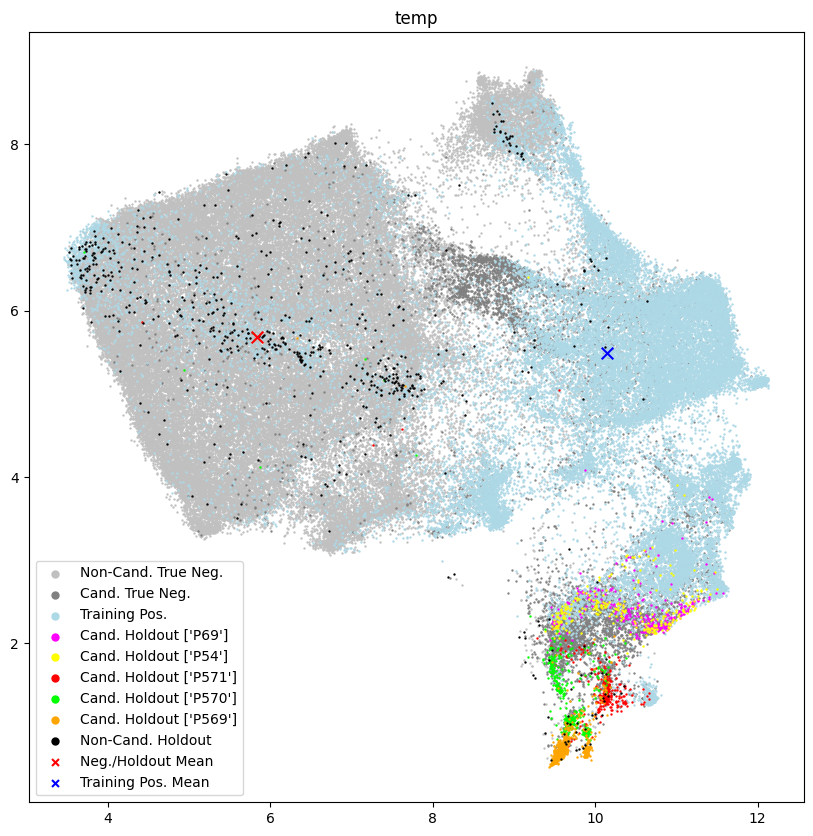

In [27]:
p_pos_mask, p_holdout_mask, p_neg_mask = get_subset_masks(pos_mask, holdout_mask, neg_mask, num=120_000, mode='all_pos') # Plot all positives and holdouts w/ negatives
plot(embeddings, labels_original, id2rel_original, p_pos_mask, p_holdout_mask, p_neg_mask, cand_mask, 'temp', 'temp.png', reduce_fn=reduce_fn)

In [ ]:
p_pos_mask, p_holdout_mask, p_neg_mask = get_subset_masks(pos_mask, holdout_mask, neg_mask, num=120_000, mode='scale') # Plot scaled everything
plot(embeddings, labels_original, id2rel_original, p_pos_mask, p_holdout_mask, p_neg_mask, cand_mask, 'temp', 'temp.png', reduce_fn=reduce_fn)

Dimension Reducing...
PLOT NUM POS: 0
PLOT NUM HOLDOUT: 0
PLOT NUM NEG: 120000


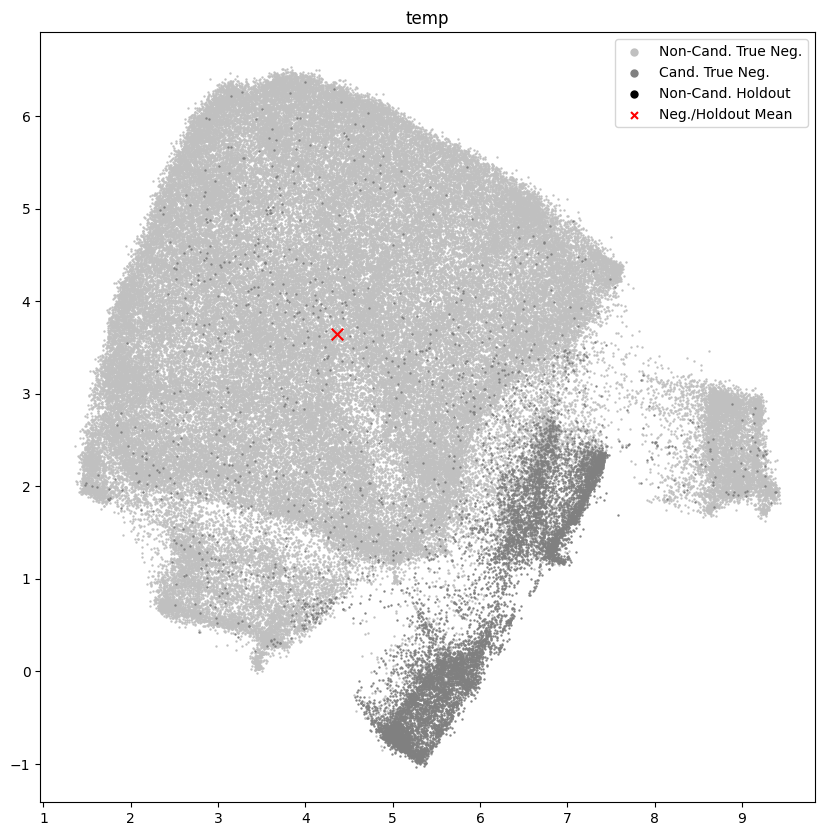

In [30]:
p_pos_mask, p_holdout_mask, p_neg_mask = get_subset_masks(pos_mask, torch.zeros_like(holdout_mask), neg_mask, num=120_000, mode='only_holdout') # Plot only negatives
plot(embeddings, labels_original, id2rel_original, p_pos_mask, p_holdout_mask, p_neg_mask, cand_mask, 'temp', 'temp.png', reduce_fn=reduce_fn)

Dimension Reducing...
PLOT NUM POS: 0
PLOT NUM HOLDOUT: 2988
PLOT NUM NEG: 117012
PLOT LABEL: ['P69'] (285) candidates, 22 non-candidates
PLOT LABEL: ['P54'] (272) candidates, 101 non-candidates
PLOT LABEL: ['P571'] (280) candidates, 180 non-candidates
PLOT LABEL: ['P570'] (634) candidates, 170 non-candidates
PLOT LABEL: ['P569'] (903) candidates, 141 non-candidates


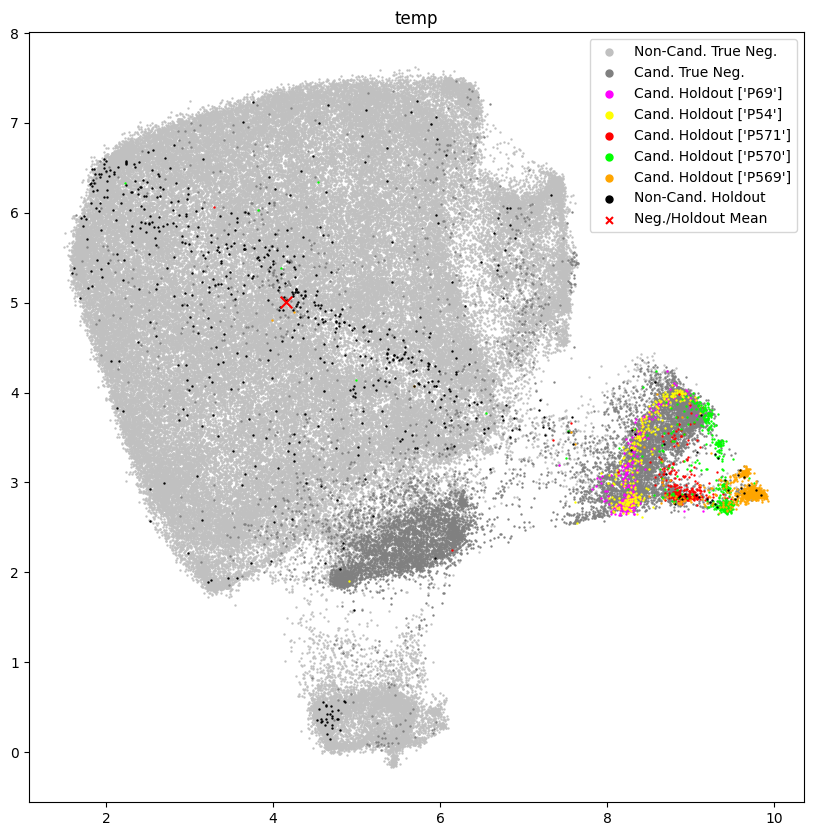

In [29]:
p_pos_mask, p_holdout_mask, p_neg_mask = get_subset_masks(pos_mask, holdout_mask, neg_mask, num=120_000, mode='only_holdout') # Plot only negatives and holdouts
plot(embeddings, labels_original, id2rel_original, p_pos_mask, p_holdout_mask, p_neg_mask, cand_mask, 'temp', 'temp.png', reduce_fn=reduce_fn)

In [ ]:
p_pos_mask, p_holdout_mask, p_neg_mask = get_subset_masks(pos_mask, holdout_mask, torch.zeros_like(neg_mask), num=120_000, mode='all_pos') # Plot only positives and holdouts no negatives
plot(embeddings, labels_original, id2rel_original, p_pos_mask, p_holdout_mask, p_neg_mask, cand_mask, 'temp', 'temp.png', reduce_fn=reduce_fn)